## MNIST Handwritten Digit Classification Dataset

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

It is a widely used and deeply understood dataset and, for the most part, is “solved.” Top-performing models are deep learning convolutional neural networks that achieve a classification accuracy of above 99%, with an error rate between 0.4% and 0.2% on the hold out test dataset.

The example below loads the MNIST dataset using the Keras API and creates a plot of the first nine images in the training dataset.

In [1]:
dark_mode = True
# plotting choices for dark-mode ... comment out if not using dark mode!!!",
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

## Define a load_dataset() function

In [2]:
def load_dataset(data_slice_train = 60000, data_slice_test = 12000):
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    trainX = trainX[:data_slice_train,:]
    trainY = trainY[:data_slice_train,:]
    testX = testX[:data_slice_test,:]
    testY = testY[:data_slice_test,:]

    return trainX, trainY, testX, testY

## Convert data

Next, let's convert the pixel data from integers to floats, and also let's rescale all the numbers to a value between 0 and 1.  We will write function to do this, so that we can use it for various datasets.

In [3]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

## Define Model

Next, we need to define a baseline convolutional neural network model for the problem.

The model has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.

For the convolutional front-end, we can start with a single convolutional layer with a small filter size (3,3) and a modest number of filters (32) followed by a max pooling layer. The filter maps can then be flattened to provide features to the classifier.

Given that the problem is a multi-class classification task, we know that we will require an output layer with 10 nodes in order to predict the probability distribution of an image belonging to each of the 10 classes. This will also require the use of a softmax activation function. Between the feature extractor and the output layer, we can add a dense layer to interpret the features, in this case with 100 nodes.

All layers will use the ReLU activation function and the He weight initialization scheme, both best practices.

We will use a conservative configuration for the stochastic gradient descent optimizer with a learning rate of 0.01 and a momentum of 0.9. The categorical cross-entropy loss function will be optimized, suitable for multi-class classification, and we will monitor the classification accuracy metric, which is appropriate given we have the same number of examples in each of the 10 classes.

The define_model() function below will define and return this model.

In [4]:
# define cnn model
def define_model(n_filters=32,filter_size=3,pool_size=2,fclayer=100,lrate=0.01,mom=0.9):
    model = Sequential()
    model.add(Conv2D(n_filters, (filter_size, filter_size), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((pool_size, pool_size)))
    model.add(Flatten())
    model.add(Dense(fclayer, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(lr=lrate, momentum=mom)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Evaluate Model

After the model is defined, we need to evaluate it.

The model will be evaluated using five-fold cross-validation. The value of k=5 was chosen to provide a baseline for both repeated evaluation and to not be so large as to require a long running time. Each test set will be 20% of the training dataset, or about 12,000 examples, close to the size of the actual test set for this problem.

The training dataset is shuffled prior to being split, and the sample shuffling is performed each time, so that any model we evaluate will have the same train and test datasets in each fold, providing an apples-to-apples comparison between models.

We will train the baseline model for a modest 10 training epochs with a default batch size of 32 examples. The test set for each fold will be used to evaluate the model both during each epoch of the training run, so that we can later create learning curves, and at the end of the run, so that we can estimate the performance of the model. As such, we will keep track of the resulting history from each run, as well as the classification accuracy of the fold.

The evaluate_model() function below implements these behaviors, taking the training dataset as arguments and returning a list of accuracy scores and training histories that can be later summarized.

In [5]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, 
                   n_filters=32,filter_size=3,pool_size=2,fclayer=100,lrate=0.01,mom=0.9,
                   n_folds=5, n_epochs=10, batch=64):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    firstTime = True
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model(n_filters,filter_size,pool_size,fclayer,lrate,mom)
        if (firstTime):
            model.summary()
            firstTime = False
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=n_epochs, batch_size=batch, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

## Present Results

Once the model has been evaluated, we can present the results.

There are two key aspects to present: the diagnostics of the learning behavior of the model during training and the estimation of the model performance. These can be implemented using separate functions.

First, the diagnostics involve creating a line plot showing model performance on the train and test set during each fold of the k-fold cross-validation. These plots are valuable for getting an idea of whether a model is overfitting, underfitting, or has a good fit for the dataset.

We will create a single figure with two subplots, one for loss and one for accuracy. Blue lines will indicate model performance on the training dataset and orange lines will indicate performance on the hold out test dataset. The summarize_diagnostics() function below creates and shows this plot given the collected training histories.

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(histories,scores):
    fig = plt.figure(figsize=(14,7))
    ax1 = fig.add_subplot(1,3,1)
    ax2 = fig.add_subplot(1,3,2)
    ax3 = fig.add_subplot(1,3,3)
    for i in range(len(histories)):
        # plot loss
        ax1.title.set_text('Cross Entropy Loss')
        ax1.plot(histories[i].history['loss'], color='blue',label='train '+str(i+1))
        ax1.plot(histories[i].history['val_loss'], color='orange',label='test '+str(i+1))
        ax1.set_ylabel('Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        # plot accuracy
        ax2.title.set_text('Classification Accuracy')
        ax2.plot(histories[i].history['accuracy'], color='blue',label='train '+str(i+1))
        ax2.plot(histories[i].history['val_accuracy'], color='orange',label='test '+str(i+1))
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.legend() 
        # box and whisker plots of results
        ax3.title.set_text('Final Result Summary')
        ax3.boxplot(scores)
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    plt.show()

## Complete Example

We need a function that will drive the test harness.

This involves calling all of the define functions.

In [7]:
def run_test_harness(data_train_slice=60000,
                     data_test_slice=12000,
                     n_filters=32,filter_size=3,pool_size=2,fclayer=100,lrate=0.01,mom=0.9,
                     n_folds=5,n_epochs=10,batch=64):
    # load dataset
    trainX, trainY, testX, testY = load_dataset(data_train_slice,data_test_slice)
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY,
                                      n_filters,filter_size,pool_size,fclayer,lrate,mom,
                                      n_folds,n_epochs,batch)
    # learning curves
    # summarize_diagnostics(histories,scores)
    return scores, histories

In [8]:
# baseline cnn model for mnist
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from datetime import datetime

filter_size=3
pool_size=2
fclayer=100
lrate=0.01
mom=0.9
n_folds=5
n_epochs=10
batch=64

size = 15000

filters = np.array([4,8,16,32,64,128])

run_time = []
final_accuracy = []
for n_filters in filters:
    start_time = datetime.now()
    scores,histories = run_test_harness(size,int(size/5),
                                        n_filters,filter_size,pool_size,fclayer,lrate,mom,
                                        n_folds,n_epochs,batch)
    end_time = datetime.now()
    elapsed_time = end_time-start_time
    run_time.append(elapsed_time.total_seconds())
    final_accuracy.append(mean(scores)*100)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 4)         40        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 676)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               67700     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 68,750
Trainable params: 68,750
Non-trainable params: 0
_________________________________________________________________
> 96.433
> 96.833
> 96.067
> 96.867
> 96.467
Model: "sequential_5"
___________________________________________________

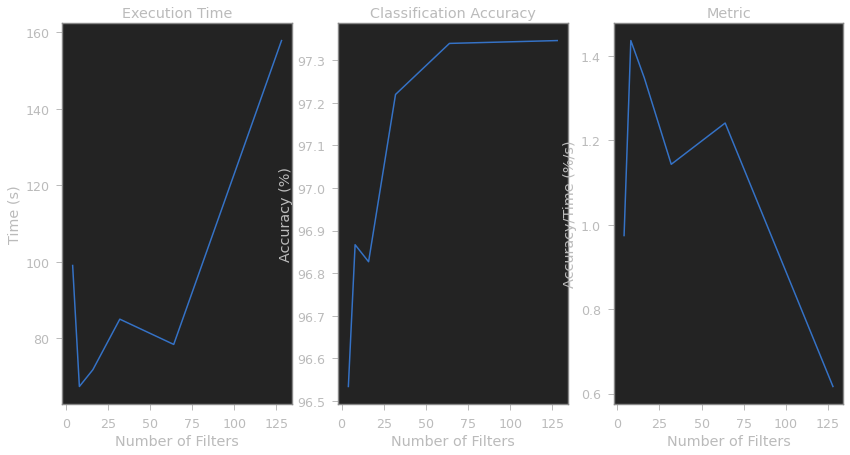

In [9]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

final_accuracy=np.array(final_accuracy)
run_time=np.array(run_time)

ax1.title.set_text('Execution Time')
ax1.plot(filters,run_time)
ax1.set_ylabel('Time (s)')
ax1.set_xlabel('Number of Filters')

ax2.title.set_text('Classification Accuracy')
ax2.plot(filters,final_accuracy)
ax2.set_ylabel('Accuracy (%)')
ax2.set_xlabel('Number of Filters')

ax3.title.set_text('Metric')
ax3.plot(filters,final_accuracy/run_time)
ax3.set_ylabel('Accuracy/Time (%/s)')
ax3.set_xlabel('Number of Filters')

plt.show()

Let's think about the various hard-coded parameters in the above exercise:

1. Number of filters (32)
2. Size of the filter (3 x 3)
3. Size of the max_pooling filter (2 x 2)
4. Number of nodes in the fully connected layer (100)
5. Learning rate of the SGD optimizer (0.01)
6. Momentum of the SGD optimizer (0.9)
7. Number of cross validation folds (5)
8. Number of epochs (10)
9. Batch Size (64)

We would like to investigate the time and accuracy dependence of each of these.  It will probably be easiest to do these investigations in separate Jupyter Notebooks.
